In [4]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((42000, 785), (28000, 784))

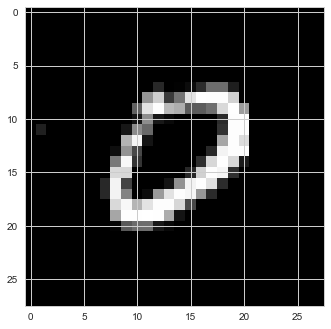

In [17]:
# 使用ndarray，而不是DataFrame
train_images = train.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_images = test.iloc[:].values

plt.imshow(test_images[3].reshape(28, 28), cmap='gray')

# Full-connected Neural Network via TensorFlow

In [81]:
import tensorflow as tf
import math

BATCH_SIZE = 100
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32
NUM_CLASSES = 10
LEARNING_RATE = 0.01
MAX_STEPS = 2000

In [82]:
images_placeholder = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_PIXELS), name='input_images')
labels_placeholder = tf.placeholder(tf.int32, shape=(BATCH_SIZE), name='input_labels')

## 1. Build Graph

### 1.1 Inference

Hidden Layer 1

In [83]:
with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, HIDDEN1_UNITS], 
                                          stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))), name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN1_UNITS]), name='biases')
    hidden1_layer = tf.nn.relu(tf.matmul(images_placeholder, weights) + biases)

Hidden Layer 2

In [84]:
with tf.name_scope('hidden2'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN1_UNITS, HIDDEN2_UNITS], 
                                          stddev=1.0 / math.sqrt(float(HIDDEN1_UNITS))), name='weights')
    biases = tf.Variable(tf.zeros([HIDDEN2_UNITS]), name='biases')
    hidden2_layer = tf.nn.relu(tf.matmul(hidden1_layer, weights) + biases)

Softmax

In [85]:
with tf.name_scope('softmax'):
    weights = tf.Variable(tf.truncated_normal([HIDDEN2_UNITS, NUM_CLASSES], 
                                          stddev=1.0 / math.sqrt(float(HIDDEN2_UNITS))), name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    logits = tf.matmul(hidden2_layer, weights) + biases

### 1.2 Loss

In [86]:
labels_placeholder = tf.to_int64(labels_placeholder)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels_placeholder, logits=logits,
                                                              name='cross_entropy')
loss = tf.reduce_mean(cross_entropy, name='loss')
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss_1:0' shape=() dtype=string>

### 1.3 Train

In [88]:
train_op = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss, name='GD_minimize')

###  1.4 Evaluation

In [89]:
correct = tf.nn.in_top_k(logits, labels_placeholder, 1)
score_op = tf.reduce_sum(tf.cast(correct, tf.int32), name='score')

### 1.5 Summary Op

In [90]:
summary_op = tf.summary.merge_all()

## 2. Graph Built, Run within Session

In [93]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter("./log2/", sess.graph)

In [94]:
for step in range(MAX_STEPS):
    TRAIN_SIZE = train_images.shape[0]
    start_idx = BATCH_SIZE * step % TRAIN_SIZE
    end_idx = start_idx + BATCH_SIZE

    if end_idx >= TRAIN_SIZE:
        start_idx = (end_idx + BATCH_SIZE) % TRAIN_SIZE
        end_idx = start_idx + BATCH_SIZE
    
    feed_dict = {
        images_placeholder: train_images[start_idx:end_idx, :],
        labels_placeholder: train_labels[start_idx:end_idx]
    }
    _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
    
    if step % 200 == 0:
        summary_str = sess.run(summary_op, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()

    if step % 500 == 0 or step == MAX_STEPS - 1:
        score = sess.run(score_op, feed_dict=feed_dict)
        saver.save(sess, "./log/cp-file.ckpt", global_step=step)
        print ("Score: %d" % score)

print ('done')

Score: 17
Score: 9
Score: 13
Score: 9
Score: 6
done


In [50]:
saver.save(sess, "./log/sth2.ckpt")

'./log/sth2.ckpt'

# Full-connected Neural Network via TensorFlow Higher API

In [115]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)

train_images = train.iloc[:, 1:].values
train_labels = train.iloc[:, 0].values
test_images = test.iloc[:].values


SAMPLE_SIZE = 5000
X_all = train_images[:SAMPLE_SIZE].copy()
y_all = train_labels[:SAMPLE_SIZE].copy()
X_test = test_images[:].copy()

# sharpen
X_all[X_all < 32] = 0
X_all[X_all >= 32] = 1
X_test[X_test < 32] = 0
X_test[X_test >= 32] = 1


In [124]:
SAMPLE_SIZE = 2000

X_all = train.iloc[:SAMPLE_SIZE, 1:].copy()
y_all = train.iloc[:SAMPLE_SIZE, 0].copy()
X_test = test.iloc[:].copy()

# sharpen
X_all[X_all < 32] = 0
X_all[X_all >= 32] = 1
X_test[X_test < 32] = 0
X_test[X_test >= 32] = 1

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size = 0.3)

### TF CNN with Higher API

In [125]:
BATCH_SIZE = 100
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32
NUM_CLASSES = 10
LEARNING_RATE = 0.01
MAX_STEPS = 2000

TARGET = 'label'
FEATURES = [f for f in X_train.columns.values if f != TARGET]

In [142]:
def input_fn(X, y):
    return tf.constant(X.values), tf.constant(y.values)

In [ ]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    X_val,
    y_val,
    every_n_steps=50)

In [147]:
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=784, dtype=tf.float64)]

classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[HIDDEN1_UNITS, HIDDEN2_UNITS, NUM_CLASSES],
                                            n_classes=NUM_CLASSES,
                                            model_dir="./model",
                                            config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ccaed30>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}


In [148]:
classifier.fit(input_fn=lambda: input_fn(X_train, y_train), steps=1000, monitors=[validation_monitor])

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 2.34604, step = 1
INFO:tensorflow:Saving checkpoints for 100 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.362203.


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x11ccaefd0>, 'hidden_units': [128, 32, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x11955e840>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [149]:
accuracy_score = classifier.evaluate(input_fn=lambda: input_fn(X_val, y_val), steps=1)
accuracy_score

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-05-22-07:11:19
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-100
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-05-22-07:11:20
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.835, global_step = 100, loss = 0.525015


{'accuracy': 0.83499998, 'global_step': 100, 'loss': 0.52501547}

In [163]:
prediction = list(classifier.predict(input_fn=lambda: test.values, outputs="classes"))
prediction

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-100


[{'classes': 2},
 {'classes': 0},
 {'classes': 9},
 {'classes': 9},
 {'classes': 3},
 {'classes': 7},
 {'classes': 0},
 {'classes': 3},
 {'classes': 0},
 {'classes': 3},
 {'classes': 5},
 {'classes': 7},
 {'classes': 4},
 {'classes': 0},
 {'classes': 4},
 {'classes': 5},
 {'classes': 3},
 {'classes': 1},
 {'classes': 9},
 {'classes': 0},
 {'classes': 9},
 {'classes': 1},
 {'classes': 1},
 {'classes': 5},
 {'classes': 7},
 {'classes': 4},
 {'classes': 2},
 {'classes': 7},
 {'classes': 7},
 {'classes': 7},
 {'classes': 7},
 {'classes': 5},
 {'classes': 4},
 {'classes': 2},
 {'classes': 6},
 {'classes': 2},
 {'classes': 0},
 {'classes': 5},
 {'classes': 8},
 {'classes': 6},
 {'classes': 7},
 {'classes': 7},
 {'classes': 4},
 {'classes': 9},
 {'classes': 5},
 {'classes': 7},
 {'classes': 8},
 {'classes': 8},
 {'classes': 6},
 {'classes': 7},
 {'classes': 6},
 {'classes': 8},
 {'classes': 1},
 {'classes': 3},
 {'classes': 8},
 {'classes': 2},
 {'classes': 1},
 {'classes': 2},
 {'classes': 4